In [1]:
# 梯度下降实现矩阵分解

In [11]:
#构造数据集 -- 将矩阵用dataframe的形式表现出来
import numpy as np
import pandas as pd
num_user = 5
num_item = 5
latent = 2

Y_gt = np.array([
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1],
], dtype=np.float)
Y = Y_gt.copy()
Y[0, 4] = Y[1, 3] = Y[2, 2] = Y[3, 1] = Y[4, 0] = None

dataset = pd.DataFrame(columns=['user', 'item', 'score'])
for u in range(num_user):
    for i in range(num_item):
        if np.isnan(Y[u, i]):
            continue
        dataset = dataset.append({
            'user' : u,
            'item' : i,
            'score' : Y[u, i]
        }, ignore_index=True)
print(dataset) # 5 * 5的矩阵 还差5个缺失值

    user  item  score
0    0.0   0.0    1.0
1    0.0   1.0    1.0
2    0.0   2.0    1.0
3    0.0   3.0    0.0
4    1.0   0.0    1.0
5    1.0   1.0    1.0
6    1.0   2.0    1.0
7    1.0   4.0    0.0
8    2.0   0.0    1.0
9    2.0   1.0    1.0
10   2.0   3.0    0.0
11   2.0   4.0    0.0
12   3.0   0.0    0.0
13   3.0   2.0    0.0
14   3.0   3.0    1.0
15   3.0   4.0    1.0
16   4.0   1.0    0.0
17   4.0   2.0    0.0
18   4.0   3.0    1.0
19   4.0   4.0    1.0


/var/folders/zb/364yznl52m77t2qs4wsb69w40000gn/T/ipykernel_62326/3821757232.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ], dtype=np.float)


In [13]:
# 初始模型参数
def initial_para():
    P = np.random.randn(num_user, latent)
    Q = np.random.randn(latent, num_item)
    p = np.zeros(num_user, dtype=np.float) # 用户偏置 -- 用于简化计算
    q = np.zeros(num_item, dtype=np.float) # 项目偏置
    c = 0.0 # 整体偏置
    return P, Q, p, q, c
initial_para()

/var/folders/zb/364yznl52m77t2qs4wsb69w40000gn/T/ipykernel_62326/106588209.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.zeros(num_user, dtype=np.float) # 用户偏置 -- 用于简化计算
/var/folders/zb/364yznl52m77t2qs4wsb69w40000gn/T/ipykernel_62326/106588209.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  q = np.zeros(num_item, dtype=n

(array([[-0.10900345, -0.23392182],
        [-0.75014198, -0.42008468],
        [-0.70792151, -0.55196035],
        [ 0.40426556, -0.98659875],
        [ 0.81427984, -1.59573584]]),
 array([[-0.0362279 ,  2.11789256, -0.32275057, -0.02707437, -1.05080128],
        [ 1.39128181, -1.13451187,  0.70246206, -1.23051179,  1.03553693]]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 0.0)

In [14]:
# 打印模型参数
def print_para(P = None, Q = None, p = None, q = None, c = None):
    if P is not None: print('P = \n', np.around(P, 2))
    if Q is not None: print('Q = \n', np.around(Q, 2))
    if p is not None: print('p = ', np.around(p, 2))
    if q is not None: print('q = ', np.around(q, 2))
    if c is not None: print('c = ', np.around(c, 2))

In [35]:
# 模型训练
lr = 1e-2
lambda_l2 = 1e-2 # 正则化参数
num_epoch = 400  # 测试后400是最佳的 网站上的500会过拟合
loss = []  # 记录loss
P, Q, p, q, c = initial_para()
idx_shuffle = np.arange(len(dataset)) # 给数据进行排序
for epoch in range(num_epoch):
    loss_err = 0.0
    np.random.shuffle(idx_shuffle) # 打乱顺序
    for idx in idx_shuffle:
        u = int(dataset.iloc[idx]['user'])
        i = int(dataset.iloc[idx]['item'])
        gt = dataset.iloc[idx]['score']
        # 前向传播
        score = np.dot(P[u, :], Q[:, i]) + p[u] + q[i] + c
        eui = score - gt
        # 均方误差
        loss_err += eui ** 2
        # 反向传播 梯度下降
        P[u, :] -= lr * (2 * eui * Q[:, i] + 2 * lambda_l2 * P[u, :])
        Q[:, i] -= lr * (2 * eui * P[u, :] + 2 * lambda_l2 * Q[:, i])
        p[u] -= lr * (2 * eui + 2 * lambda_l2 * p[u])
        q[i] -= lr * (2 * eui + 2 * lambda_l2 * q[i])
        c -= lr * (2 * eui + 2 * lambda_l2 * c)
    # 正则化误差
    loss_l2 = lambda_l2 * np.linalg.norm(P, ord=2) + \
              lambda_l2 * np.linalg.norm(Q, ord=2) + \
              lambda_l2 * np.linalg.norm(p, ord=2) + \
              lambda_l2 * np.linalg.norm(q, ord=2) + \
              lambda_l2 * np.abs(c)
    loss.append(loss_err + loss_l2)
    if epoch % 100 == 0:
        print('Epoch=%03d, Loss=%1.6f, L2=%1.6f, lr=%1.6f'%(epoch, loss_err, loss_l2, lr))

Epoch=000, Loss=14.778357, L2=0.034138, lr=0.010000
Epoch=100, Loss=0.055734, L2=0.041672, lr=0.010000
Epoch=200, Loss=0.013741, L2=0.041315, lr=0.010000
Epoch=300, Loss=0.007683, L2=0.040977, lr=0.010000


/var/folders/zb/364yznl52m77t2qs4wsb69w40000gn/T/ipykernel_62326/106588209.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.zeros(num_user, dtype=np.float) # 用户偏置 -- 用于简化计算
/var/folders/zb/364yznl52m77t2qs4wsb69w40000gn/T/ipykernel_62326/106588209.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  q = np.zeros(num_item, dtype=n

In [36]:
Y_re = np.matmul(P, Q) + p.reshape((-1, 1)) + q.reshape((1, -1)) + c
print_para(P, Q, p, q, c)

P = 
 [[ 0.86  0.42]
 [-0.04  0.86]
 [-0.26  0.9 ]
 [-0.4  -0.59]
 [ 0.01 -0.73]]
Q = 
 [[ 0.1   0.09  0.11 -0.45 -0.18]
 [ 0.51  0.5   0.5  -0.78 -0.76]]
p =  [ 0.32  0.18  0.18 -0.03 -0.01]
q =  [0.1  0.11 0.1  0.13 0.19]
c =  0.28


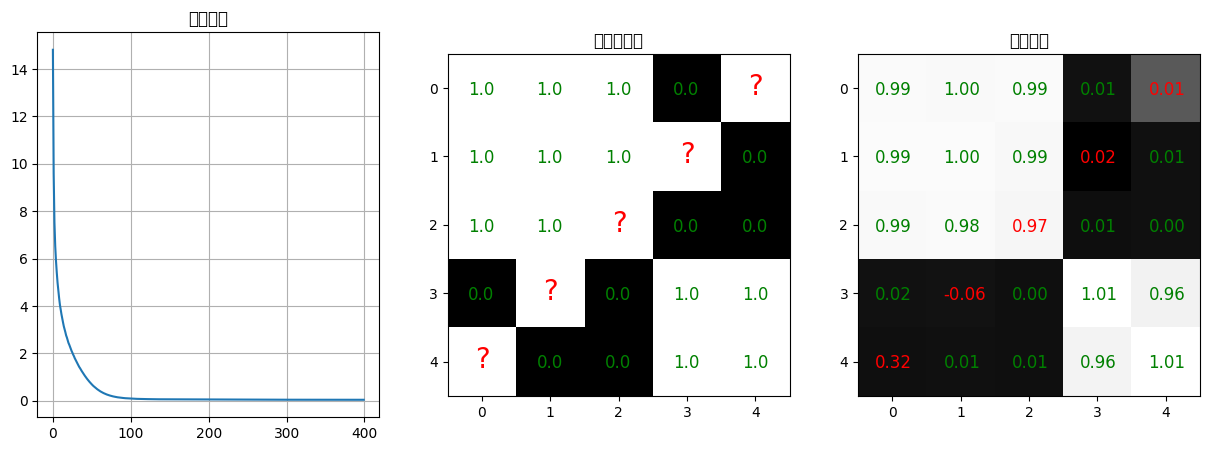

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
def show_result(curve, curve_name, Y, Y_re, figname, save=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), num=figname)
    axs[0].plot(curve)             
    axs[0].grid()
    axs[0].set_title(curve_name)
    axs[1].imshow(Y, cmap='gray')   # 待预测/填充数据
    axs[1].set_title('待填充数据')
    axs[2].imshow(Y_re, cmap='gray')# 填充/预测结果
    axs[2].set_title('预测填充')
    for u in range(num_user):
        for i in range(num_item):
            if np.isnan(Y[u,i]):
                axs[1].text(u-0.1, i+0.1, '?', fontsize=20, color='r')
                axs[2].text(u-0.25, i+0.1, '%1.2f'%Y_re[u, i], fontsize=12, color='r')
            else:
                axs[1].text(u-0.2, i+0.1, str(Y[u, i]), fontsize=12, color='g')
                axs[2].text(u-0.25, i+0.1, '%1.2f'%Y_re[u, i], fontsize=12, color='g')
show_result(curve=loss, curve_name='损失函数', Y=Y, Y_re=Y_re, figname='SGD_linear', save=True)